What is Layer Normalization?

Layer Normalization (LayerNorm) is a normalization technique that normalizes the activations across the features of a single training example, rather than across the batch.

1. Stabilizes training in deep transformer stacks   
    Transformers are extremely deep, and activations can explode or vanish without normalization.
    LayerNorm keeps activations within a consistent range at every layer, preventing:
    gradient explosion
    gradient vanishing
    This enables training hundreds of layers.
   
2. Independent of batch size   
    LLMs often train with variable-length sequences
    small batch sizes due to memory
    sequence-parallel or pipeline-parallel distribution
    BatchNorm depends on batch statistics, which become noisy when batch size is small.
    LayerNorm uses per-token statistics, so it works even with batch size 1.

3. Prevents internal covariate shift in self-attention   
    Self-attention mixes information across tokens, and tiny changes can destabilize deeper layers.
    LayerNorm reduces this shift by normalizing each layer’s output, making training predictable even with:
    long sequences
    large vocabularies
    huge embedding sizes



   

x = [2.0, -1.0, 4.0, 3.0]    

step 1 - mean = μ=(2−1+4+3)/4=2.0
   
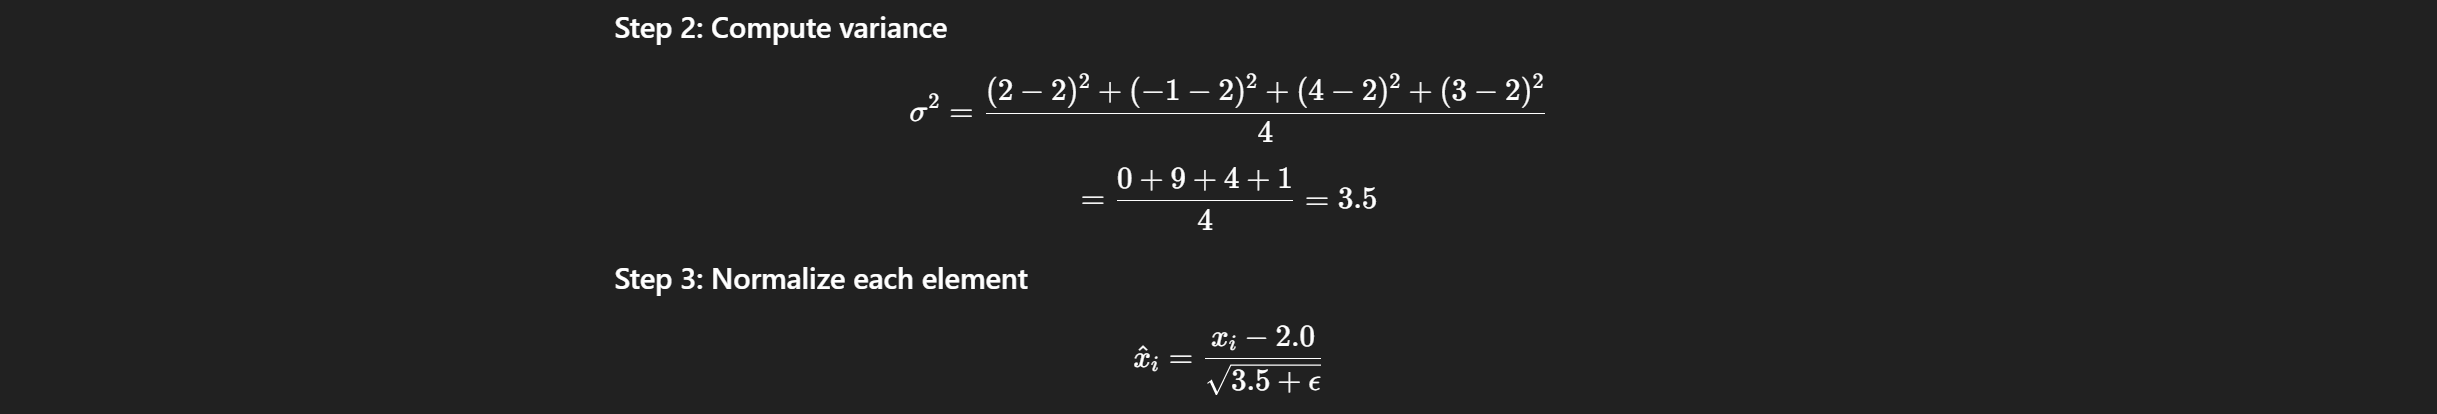

now this output becomes - => [0, -1.60, 1.07, 0.53]


In [8]:
import torch.nn as nn
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-warning">

This specific implementation of layer Normalization operates on the last dimension of the
input tensor x, which represents the embedding dimension (emb_dim). 

The variable eps is a
small constant (epsilon) added to the variance to prevent division by zero during
normalization. 

The scale and shift are two trainable parameters (of the same dimension
as the input) that the LLM automatically adjusts during training if it is determined that
doing so would improve the model's performance on its training task. 

This allows the model
to learn appropriate scaling and shifting that best suit the data it is processing.

</div>

In [9]:
import torch
batch_example = torch.randn(2, 5) #A
batch_example

tensor([[-1.2641, -2.3228,  0.2744,  0.0358,  0.0849],
        [-0.1399, -0.5084, -0.1014,  0.0817,  0.8372]])

In [10]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[ 1.1921e-08],
        [-5.3644e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [0.9999]], grad_fn=<VarBackward0>)


In [11]:
out_ln

tensor([[-0.6233, -1.6778,  0.9092,  0.6715,  0.7204],
        [-0.3903, -1.2185, -0.3039,  0.1075,  1.8052]], grad_fn=<AddBackward0>)


      
We use Layer Normalization instead of Batch Normalization in LLMs because:

1. BatchNorm depends on batch statistics, but LLMs often train with very small or variable batch sizes, sometimes batch size = 1.
2. Autoregressive generation runs one token at a time, so BatchNorm cannot compute batch statistics during inference.
3. Sequence lengths vary, making batch-level normalization inconsistent.
4. Parallelism (tensor, pipeline, sequence parallel) breaks BatchNorm because tokens of the same batch may be on different devices.
5. LayerNorm normalizes per token, so it is stable regardless of batch size, sequence length, or device split.